# Analisis Difusi Informasi Twitter: Keracunan MBG
Notebook ini membagi setiap bagian analisis ke dalam cell terpisah berdasarkan fungsinya untuk kemudahan eksplorasi dan modifikasi.

## 1. Import Library

In [28]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np

## 2. Load Data

In [29]:
df = pd.read_csv("KeracunanMBGClean.csv")

## 3. Preprocessing Tanggal & Sort

In [30]:
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values('created_at')

C:\Users\User\AppData\Local\Temp\ipykernel_7768\3814457756.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


## 4. Membuat Graf Interaksi Twitter

In [31]:
G = nx.DiGraph()
for _, row in df.iterrows():
    if pd.notna(row['username']) and pd.notna(row['in_reply_to_screen_name']):
        G.add_edge(row['username'], row['in_reply_to_screen_name'])

## 5. Metrik Jaringan Dasar

In [32]:
print(f"Jumlah node: {G.number_of_nodes()}")
print(f"Jumlah edge: {G.number_of_edges()}")
print(f"Kepadatan jaringan: {nx.density(G):.6f}")

Jumlah node: 413
Jumlah edge: 296
Kepadatan jaringan: 0.001740


## 6. Sentralitas & Pengguna Berpengaruh

In [101]:
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

largest_cc = max(nx.weakly_connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc).copy()
try:
    eigenvector_centrality = {node: 0 for node in G.nodes()}
    subgraph_eigenvector = nx.eigenvector_centrality_numpy(largest_subgraph, max_iter=1000)
    for node, value in subgraph_eigenvector.items():
        eigenvector_centrality[node] = value
except:
    eigenvector_centrality = {node: 0 for node in G.nodes()}

print("Top 10 Degree Centrality:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top 10 In-Degree Centrality:")
print(sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top 10 Out-Degree Centrality:")
print(sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top 10 Betweenness Centrality:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

Top 10 Degree Centrality:
[('ARSIPAJA', 0.03640776699029126), ('DS_yantie', 0.029126213592233007), ('txtdrimedia', 0.029126213592233007), ('tilehopper', 0.02427184466019417), ('TirtoID', 0.021844660194174755), ('BANGSAygSUJUD', 0.019417475728155338), ('KompasTV', 0.019417475728155338), ('AirinDatangLagi', 0.014563106796116504), ('tukang_rejceh', 0.014563106796116504), ('CNNIndonesia', 0.014563106796116504)]
Top 10 In-Degree Centrality:
[('tukang_rejceh', 0.014563106796116504), ('massulaimana', 0.012135922330097085), ('JackaSombong', 0.009708737864077669), ('T4atak', 0.007281553398058252), ('RobbyKamandanu', 0.007281553398058252), ('bangbuddie', 0.007281553398058252), ('Ruzaynnnn', 0.007281553398058252), ('AdrienMandels', 0.007281553398058252), ('malhamahkubro', 0.007281553398058252), ('youna7770', 0.0048543689320388345)]
Top 10 Out-Degree Centrality:
[('ARSIPAJA', 0.03640776699029126), ('DS_yantie', 0.029126213592233007), ('txtdrimedia', 0.029126213592233007), ('TirtoID', 0.02184466019

## 7. Deteksi Komunitas

In [34]:
try:
    from community import community_louvain
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    communities = {}
    for node, community_id in partition.items():
        communities.setdefault(community_id, []).append(node)
    print(f"Jumlah komunitas (Louvain): {len(communities)}")
except ImportError:
    connected_components = list(nx.weakly_connected_components(G))
    communities = {i: list(comp) for i, comp in enumerate(connected_components)}
    partition = {}
    for community_id, nodes in communities.items():
        for node in nodes:
            partition[node] = community_id
    print(f"Jumlah komunitas (komponen terhubung): {len(communities)}")

Jumlah komunitas (komponen terhubung): 141


## 8. Visualisasi Jaringan & Komunitas

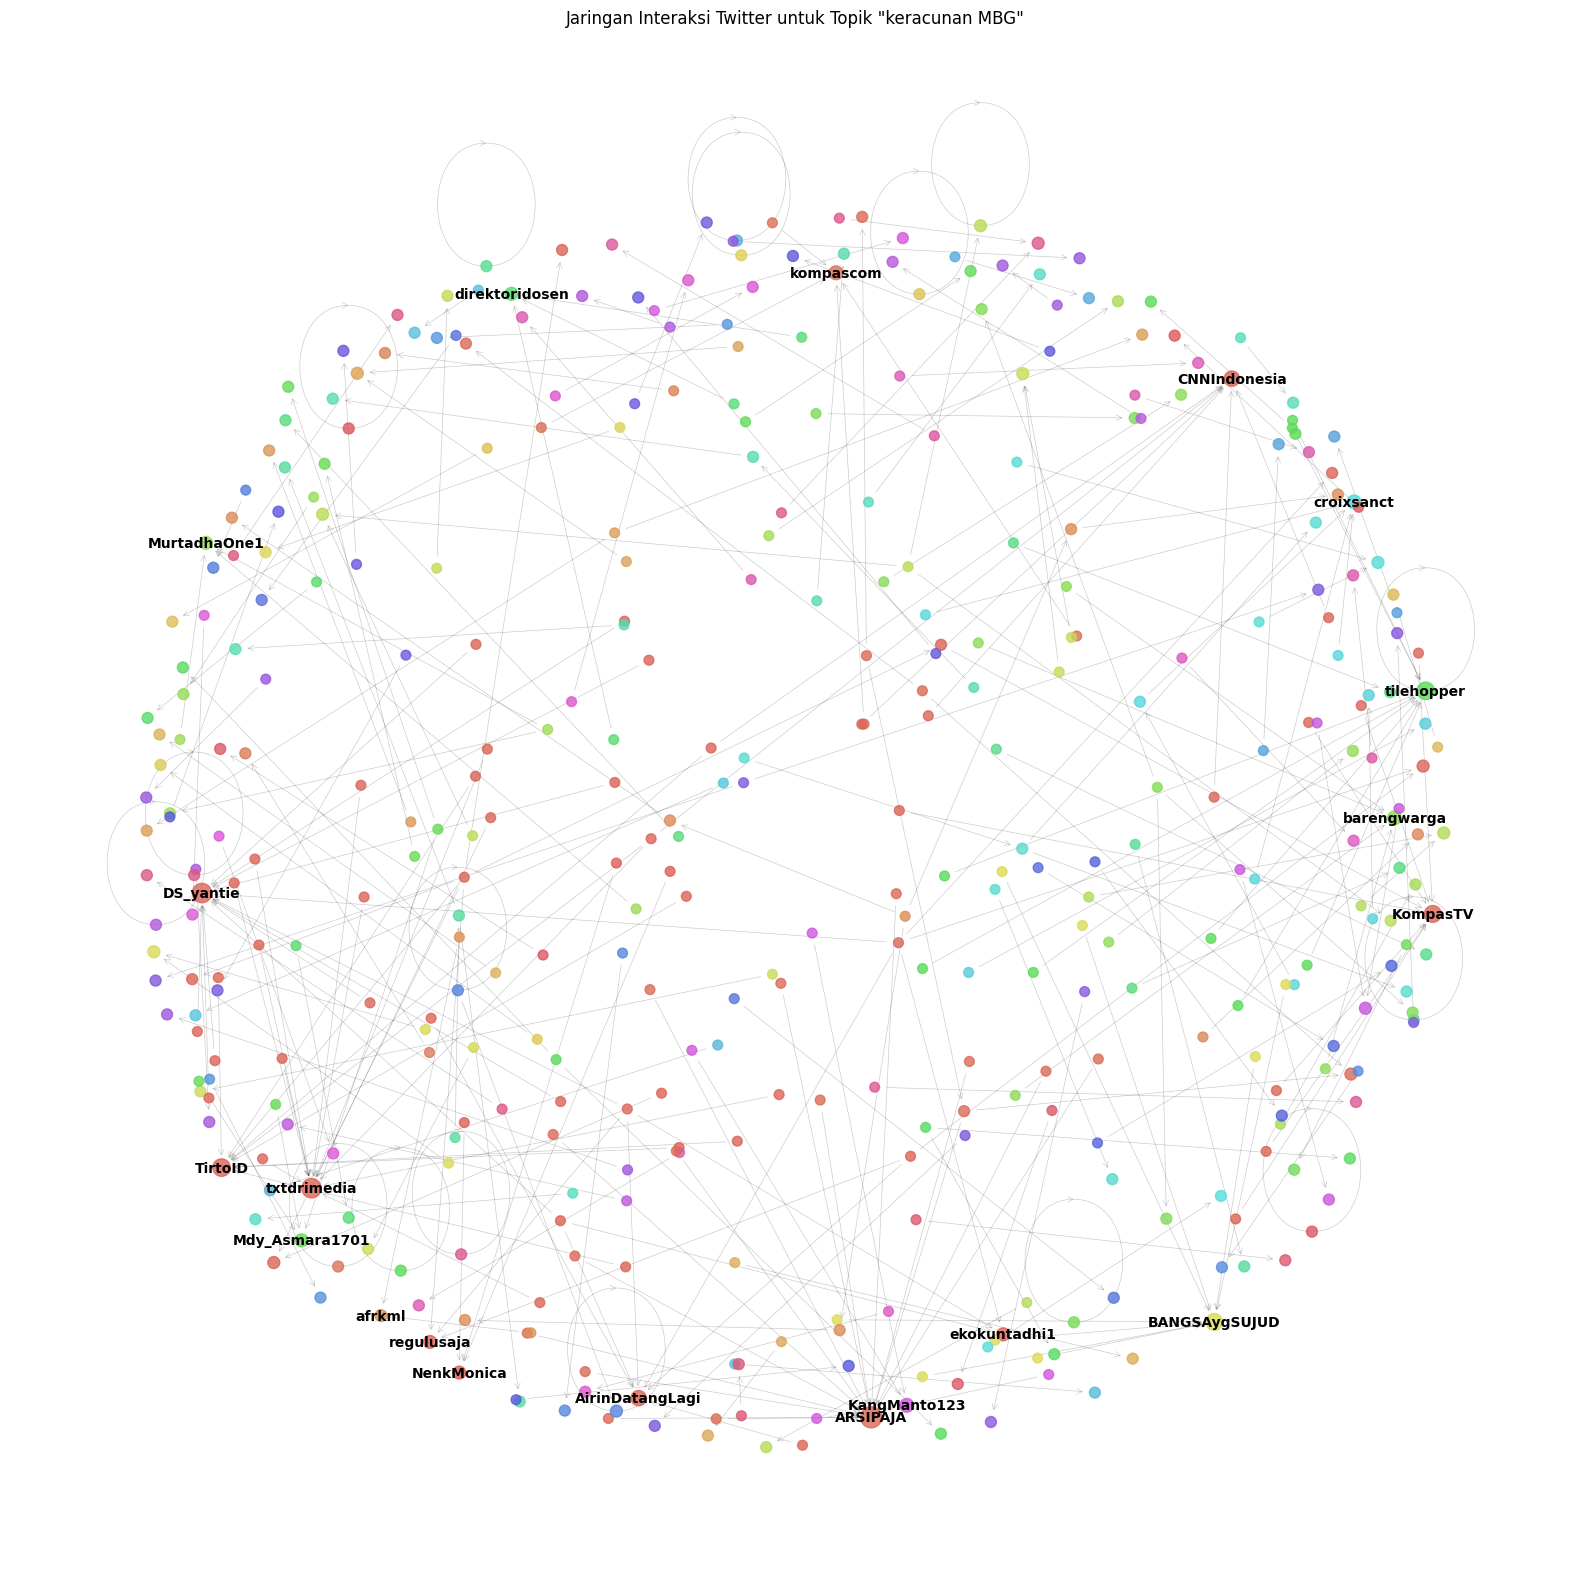

In [35]:
plt.figure(figsize=(16, 16))
num_communities = len(communities)
colors = sns.color_palette("hls", num_communities)
node_colors = [colors[partition.get(node, 0) % len(colors)] for node in G.nodes()]
node_size = [in_degree_centrality[node] * 5000 + 50 for node in G.nodes()]
if G.number_of_nodes() > 1000:
    pos = nx.kamada_kawai_layout(G)
else:
    pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, arrows=True, arrowstyle='->', arrowsize=10, width=0.5)
top_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_node_labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(G, pos, labels=top_node_labels, font_size=10, font_weight='bold')
plt.title('Jaringan Interaksi Twitter untuk Topik "keracunan MBG"')
plt.axis('off')
plt.tight_layout()
plt.savefig('jaringan_keracunan_mbg.png', dpi=300)
plt.show()

## 9. Analisis Struktur Jaringan

In [36]:
try:
    G_undirected_largest = largest_subgraph.to_undirected()
    avg_path_length = nx.average_shortest_path_length(G_undirected_largest)
    diameter = nx.diameter(G_undirected_largest)
    print(f"Rata-rata panjang jalur terpendek: {avg_path_length:.4f}")
    print(f"Diameter jaringan: {diameter}")
except:
    print("Tidak dapat menghitung metrik jalur karena komponen terbesar terlalu kecil")
clustering_coef = nx.average_clustering(G.to_undirected())
print(f"Koefisien clustering rata-rata: {clustering_coef:.4f}")
reciprocity = nx.reciprocity(G)
print(f"Reciprocity: {reciprocity:.4f}")

Rata-rata panjang jalur terpendek: 4.8885
Diameter jaringan: 9
Koefisien clustering rata-rata: 0.0000
Reciprocity: 0.0000


## 10. Analisis Temporal Penyebaran Informasi

C:\Users\User\AppData\Local\Temp\ipykernel_7768\1072354606.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cumulative_tweets = df.groupby(pd.Grouper(key='created_at', freq='H')).size().cumsum()


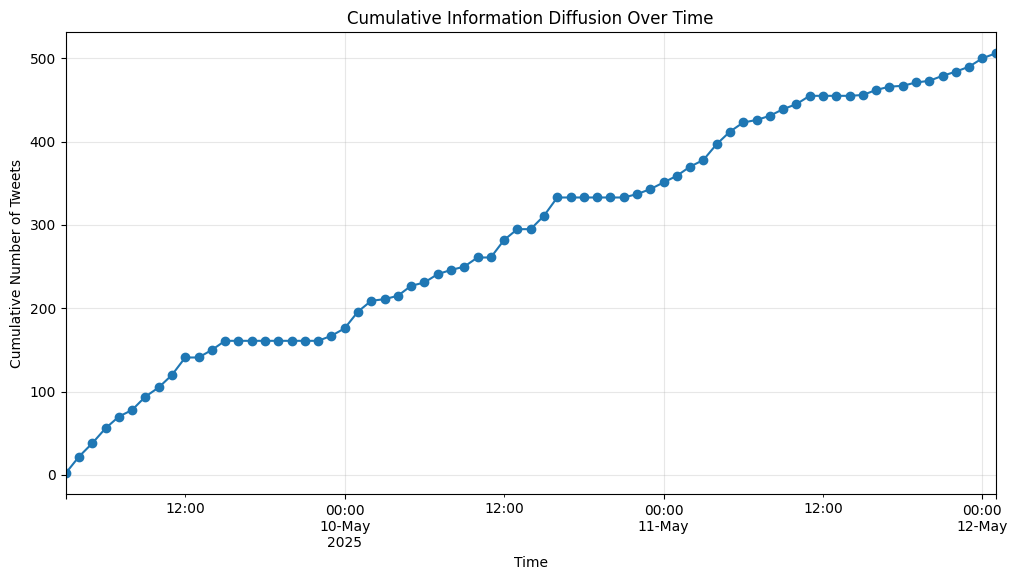

In [37]:
df['hours_since_first'] = (df['created_at'] - df['created_at'].min()).dt.total_seconds() / 3600
cumulative_tweets = df.groupby(pd.Grouper(key='created_at', freq='H')).size().cumsum()
plt.figure(figsize=(12, 6))
cumulative_tweets.plot(marker='o')
plt.title('Cumulative Information Diffusion Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Number of Tweets')
plt.grid(True, alpha=0.3)
plt.show()

## 11. Analisis Retweet Cascade & Kecepatan Difusi

Retweet data not available in the dataset


C:\Users\User\AppData\Local\Temp\ipykernel_7768\3877278061.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_tweets = df.groupby(pd.Grouper(key='created_at', freq='H')).size()


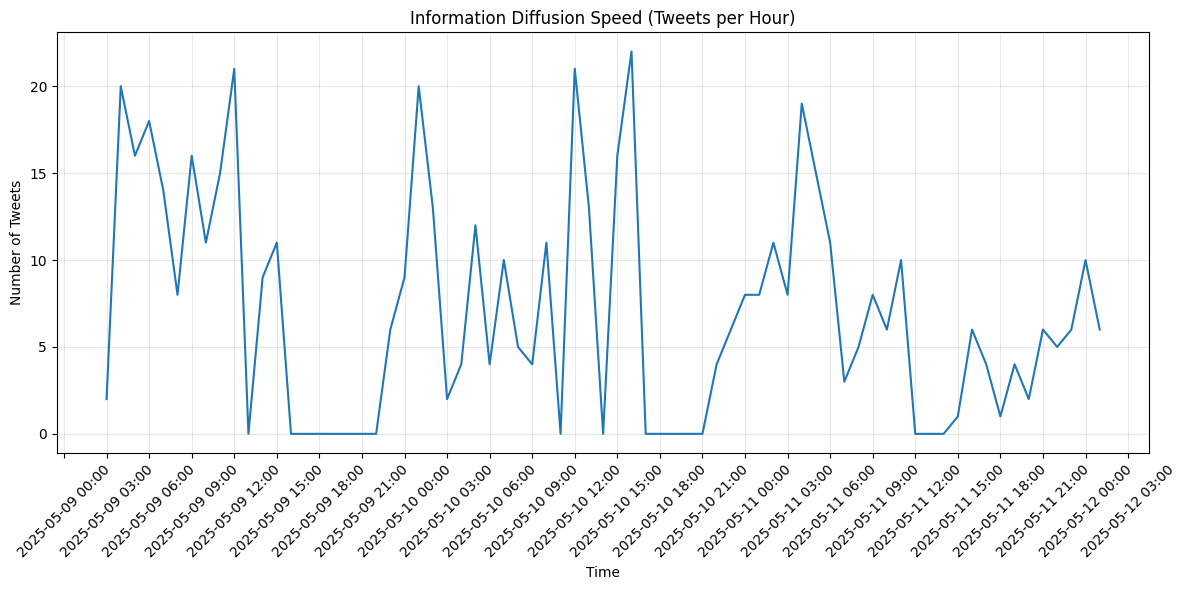

In [68]:
if 'retweeted_status_id' in df.columns:
    retweet_counts = df['retweeted_status_id'].value_counts()
    top_retweets = retweet_counts.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_retweets.values, y=top_retweets.index.astype(str))
    plt.title('Top 10 Most Retweeted Content (Cascade Size)')
    plt.xlabel('Number of Retweets')
    plt.ylabel('Tweet ID')
    plt.tight_layout()
    plt.show()
else:
    print("Retweet data not available in the dataset")

hourly_tweets = df.groupby(pd.Grouper(key='created_at', freq='H')).size()
plt.figure(figsize=(12, 6))
plt.plot(hourly_tweets.index, hourly_tweets.values)
plt.title('Information Diffusion Speed (Tweets per Hour)')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 12. Analisis Periode Aktivitas Nol & Tinggi

In [39]:
zero_hours = hourly_tweets[hourly_tweets == 0]
high_hours = hourly_tweets[hourly_tweets > hourly_tweets.quantile(0.95)]
print(f"Total hours with zero tweets: {len(zero_hours)}")
print(f"Hours with very high activity (>95th percentile): {len(high_hours)}")
print(f"Peak activity: {hourly_tweets.max()} tweets/hour at {hourly_tweets.idxmax()}")
print(f"Average tweets per hour: {hourly_tweets.mean():.2f}")

Total hours with zero tweets: 18
Hours with very high activity (>95th percentile): 3
Peak activity: 22 tweets/hour at 2025-05-10 16:00:00+00:00
Average tweets per hour: 7.13


## 13. Skor Pengaruh & Top Influencer

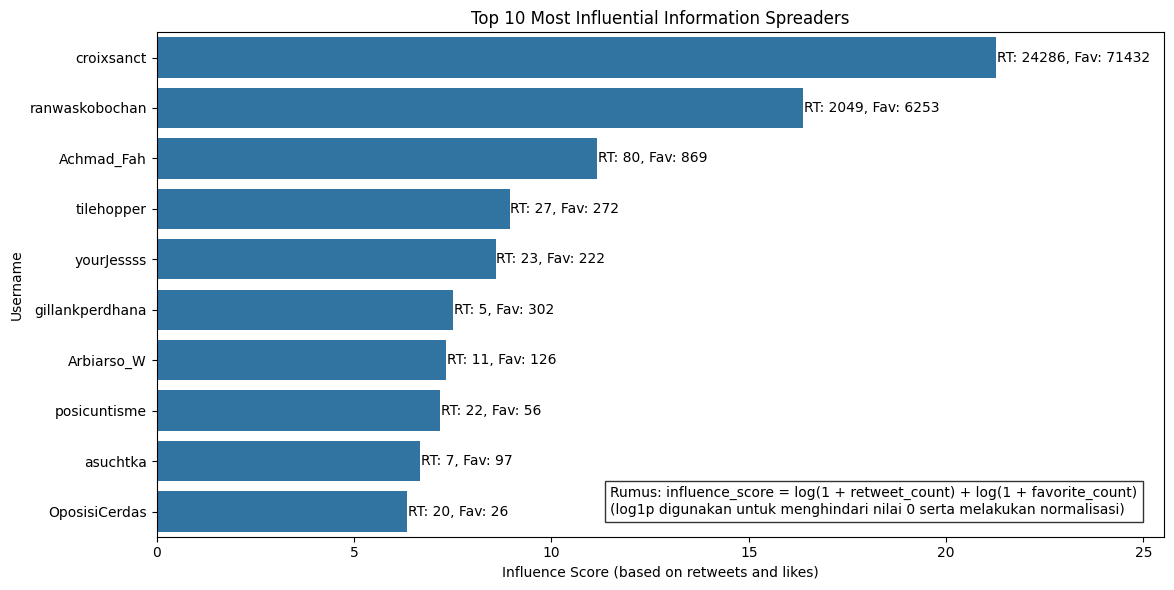

In [88]:
# Menghitung influence score dengan rumus:
# influence_score = log(1 + retweet_count) + log(1 + favorite_count)
# Penggunaan fungsi log1p (log(1+x)) menghindari masalah saat nilai count = 0 dan
# membantu menormalisasi distribusi nilai yang memiliki rentang besar.
df['influence_score'] = np.log1p(df['retweet_count']) + np.log1p(df['favorite_count'])

top_influencers = df.groupby('username')['influence_score'].sum().sort_values(ascending=False).head(10)
# Juga mengagregasi hitungan raw data untuk retweet dan favorit
agg_counts = df.groupby('username')[['retweet_count', 'favorite_count']].sum()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_influencers.values, y=top_influencers.index)
plt.title('Top 10 Most Influential Information Spreaders')
plt.xlabel('Influence Score (based on retweets and likes)')
plt.ylabel('Username')

# Menambahkan label teks untuk jumlah retweet dan favorite pada masing-masing bar
for i, username in enumerate(top_influencers.index):
    rt = agg_counts.loc[username, 'retweet_count']
    fav = agg_counts.loc[username, 'favorite_count']
    influence = top_influencers.loc[username]
    ax.text(influence + 0.02, i, f"RT: {rt}, Fav: {fav}", va='center')

max_val = top_influencers.values.max()
ax.set_xlim(0, max_val * 1.2)

# Menambahkan keterangan rumus influence score ke plot
formula_text = ("Rumus: influence_score = log(1 + retweet_count) + log(1 + favorite_count)\n"
                "(log1p digunakan untuk menghindari nilai 0 serta melakukan normalisasi)")
ax.text(0.45, 0.1, formula_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [86]:
df[df['username'] == 'croixsanct'].iloc[0]

conversation_id_str                                      1921036426860175445
created_at                                         2025-05-10 02:55:49+00:00
favorite_count                                                         71432
full_text                  Ternyata foto presiden ciuman lebih penting da...
id_str                                                   1921036426860175445
image_url                                                                NaN
in_reply_to_screen_name                                                  NaN
lang                                                                      in
location                                                                 NaN
quote_count                                                              556
reply_count                                                              178
retweet_count                                                          24286
tweet_url                  https://x.com/croixsanct/status/19210364268601...

## 14. Snapshot Temporal Jaringan

In [41]:
def create_temporal_networks(df, time_windows):
    networks = []
    for window in time_windows:
        df_subset = df[df['hours_since_first'] <= window]
        G = nx.DiGraph()
        for _, row in df_subset.iterrows():
            if pd.notna(row['username']) and pd.notna(row['in_reply_to_screen_name']):
                G.add_edge(row['in_reply_to_screen_name'], row['username'])
        networks.append((window, G))
    return networks

max_hours = df['hours_since_first'].max()
time_windows = np.linspace(max_hours/5, max_hours, 5)
temporal_networks = create_temporal_networks(df, time_windows)

## 15. Analisis Pertumbuhan Jaringan

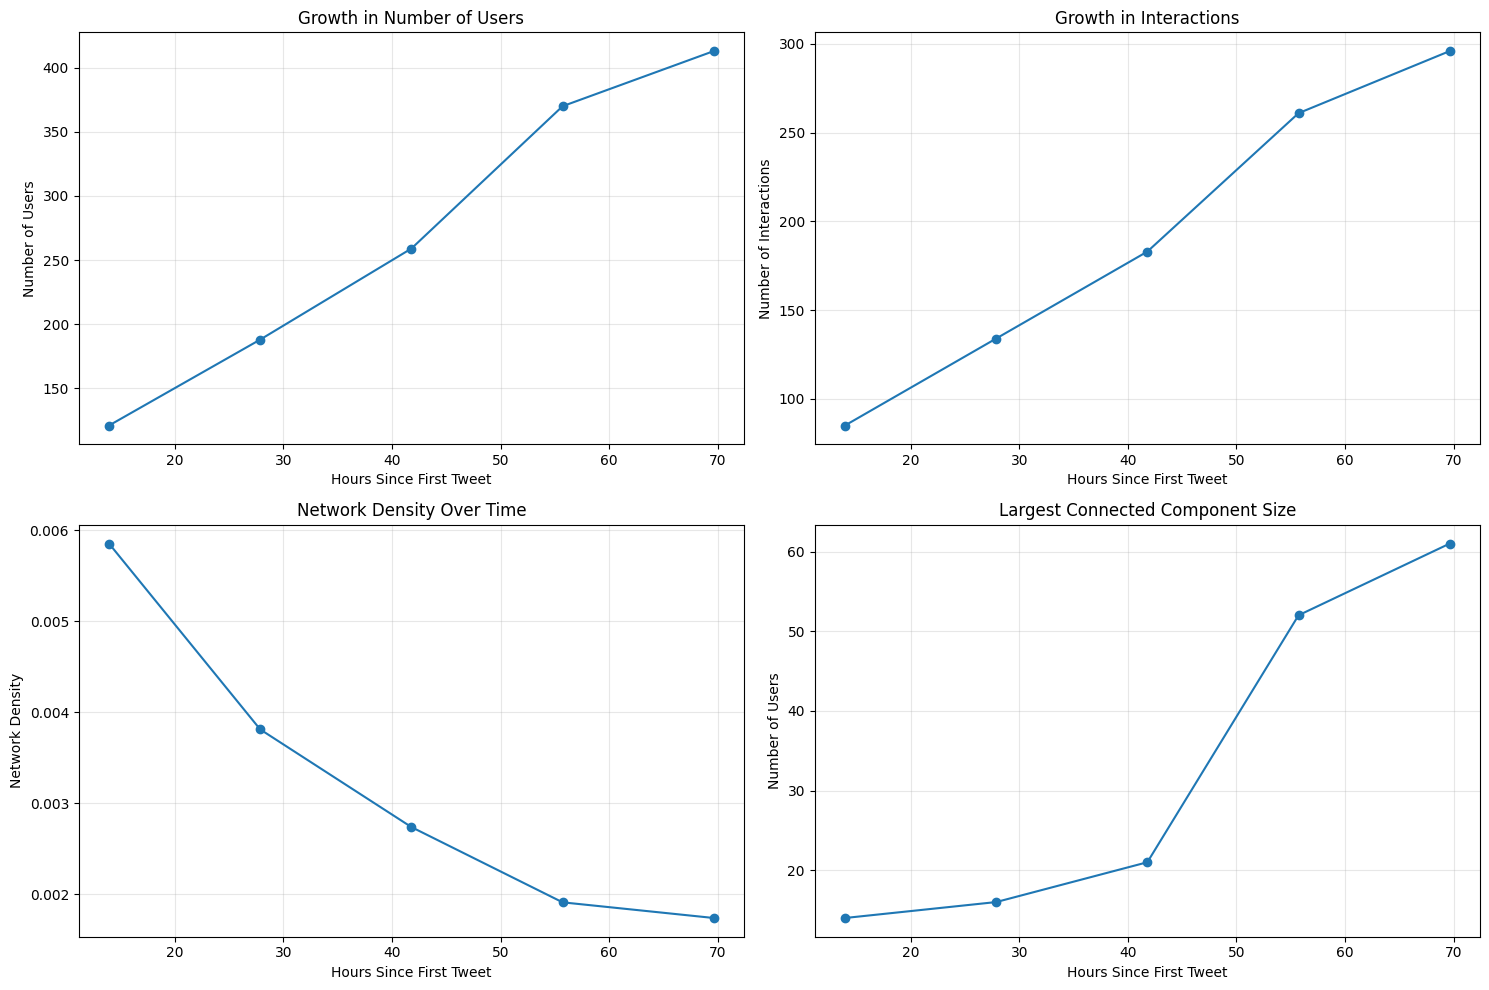

In [42]:
network_stats = []
for window, G in temporal_networks:
    stats = {
        'hours': window,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'largest_component_size': len(max(nx.weakly_connected_components(G), key=len)) if G.number_of_nodes() > 0 else 0
    }
    network_stats.append(stats)
network_df = pd.DataFrame(network_stats)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(network_df['hours'], network_df['nodes'], marker='o')
plt.title('Growth in Number of Users')
plt.xlabel('Hours Since First Tweet')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 2)
plt.plot(network_df['hours'], network_df['edges'], marker='o')
plt.title('Growth in Interactions')
plt.xlabel('Hours Since First Tweet')
plt.ylabel('Number of Interactions')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 3)
plt.plot(network_df['hours'], network_df['density'], marker='o')
plt.title('Network Density Over Time')
plt.xlabel('Hours Since First Tweet')
plt.ylabel('Network Density')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 4)
plt.plot(network_df['hours'], network_df['largest_component_size'], marker='o')
plt.title('Largest Connected Component Size')
plt.xlabel('Hours Since First Tweet')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_diffusion_metrics.png', dpi=300)
plt.show()

## 16. Visualisasi Jaringan Difusi Akhir

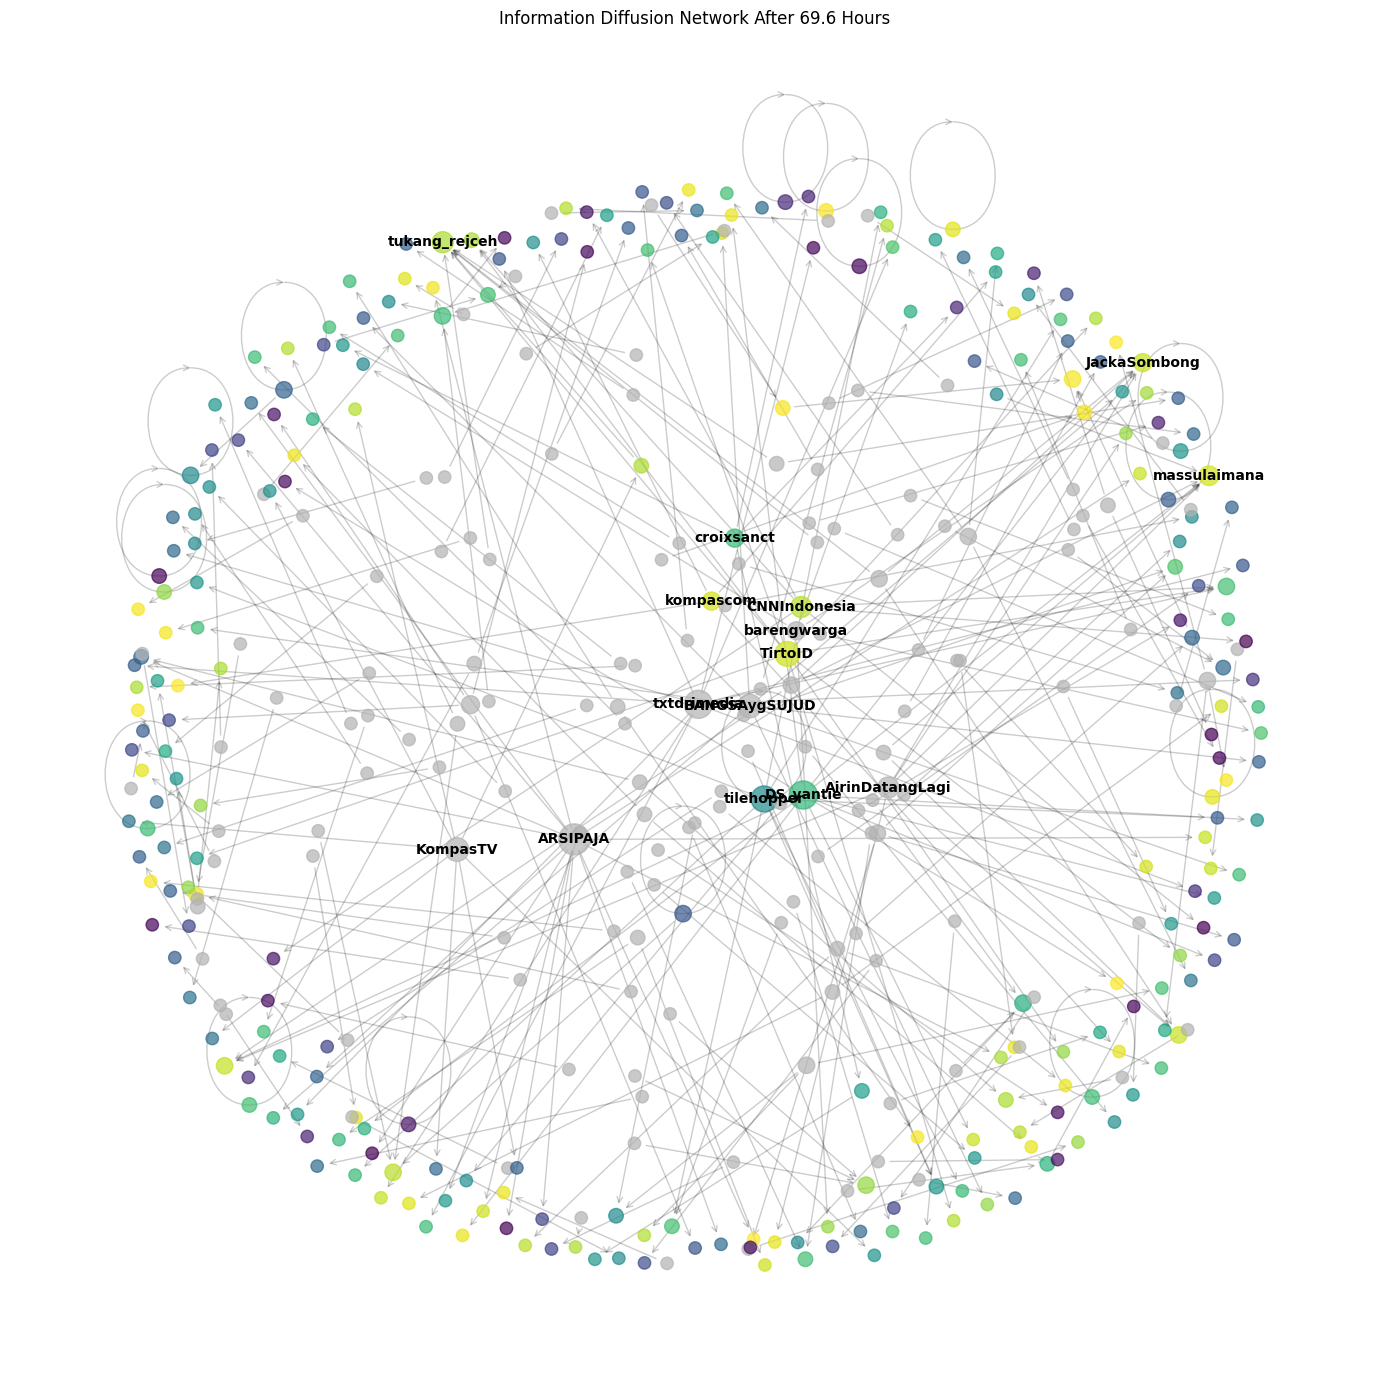

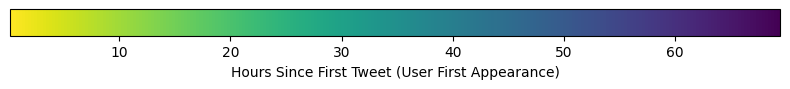

In [99]:
final_window, final_network = temporal_networks[-1]
node_size = dict(final_network.degree())
node_size = {k: (v * 30 + 50) for k, v in node_size.items()}
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(final_network, k=0.3)

# Hanya ambil user yang memang ada di df
user_set = set(df['username'])
user_first_appearance = {}
for _, row in df.sort_values('created_at').iterrows():
    if row['username'] not in user_first_appearance and row['username'] in final_network.nodes():
        user_first_appearance[row['username']] = row['hours_since_first']

if user_first_appearance:
    max_time = max(user_first_appearance.values())
    min_time = min(user_first_appearance.values())
    time_range = max_time - min_time if max_time > min_time else 1
    node_colors = [
        plt.cm.viridis(1 - (user_first_appearance[node] - min_time) / time_range)
        if node in user_first_appearance else (0.7, 0.7, 0.7, 1.0)  # abu-abu untuk node yang tidak ada di df
        for node in final_network.nodes()
    ]
else:
    node_colors = ['blue'] * len(final_network.nodes())

nx.draw_networkx_nodes(
    final_network, pos,
    node_size=[node_size.get(node, 50) for node in final_network.nodes()],
    node_color=node_colors, alpha=0.7
)
nx.draw_networkx_edges(final_network, pos, alpha=0.2, arrows=True, arrowstyle='->', arrowsize=10)
top_nodes = sorted(node_size.items(), key=lambda x: x[1], reverse=True)[:15]
node_labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(final_network, pos, labels=node_labels, font_size=10, font_weight='bold')
plt.title(f'Information Diffusion Network After {final_window:.1f} Hours')
plt.axis('off')
plt.tight_layout()
plt.savefig('final_diffusion_network.png', dpi=300)
plt.show()

from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

if user_first_appearance:
    plt.figure(figsize=(8, 1))
    norm = Normalize(vmin=min_time, vmax=max_time)
    cb = ColorbarBase(plt.gca(), cmap=plt.cm.viridis_r, norm=norm, orientation='horizontal')
    cb.set_label('Hours Since First Tweet (User First Appearance)')
    plt.tight_layout()
    plt.show()

## 17. Analisis Komponen Besar

In [100]:
num_connected_components = nx.number_weakly_connected_components(G)
print(f"Jumlah weakly connected components: {num_connected_components}")

Jumlah weakly connected components: 141


Jumlah komponen dengan size >= 5: 12


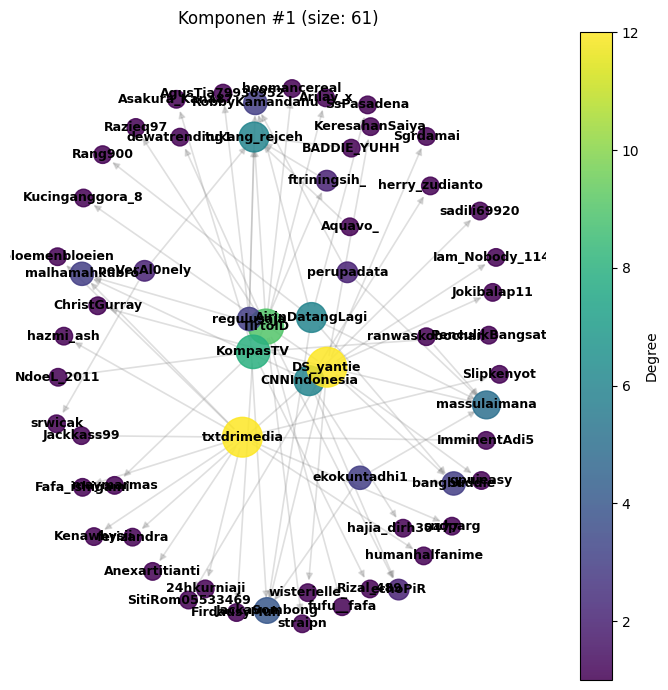

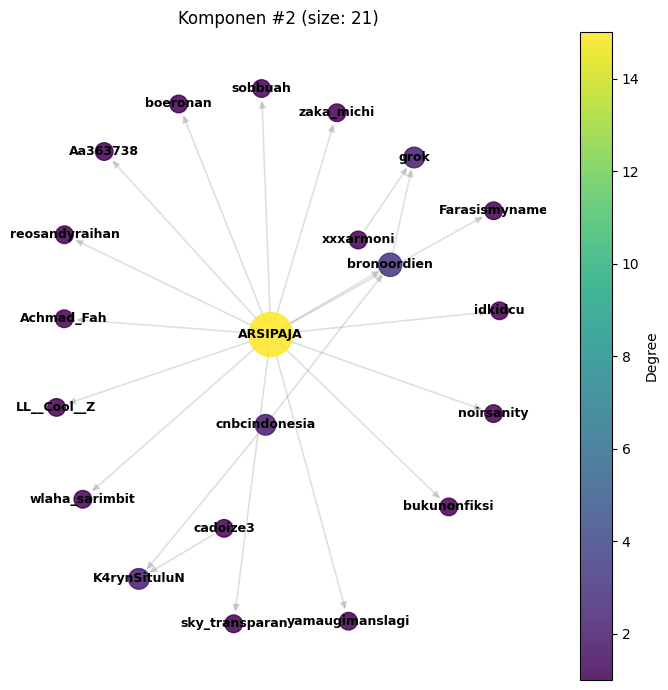

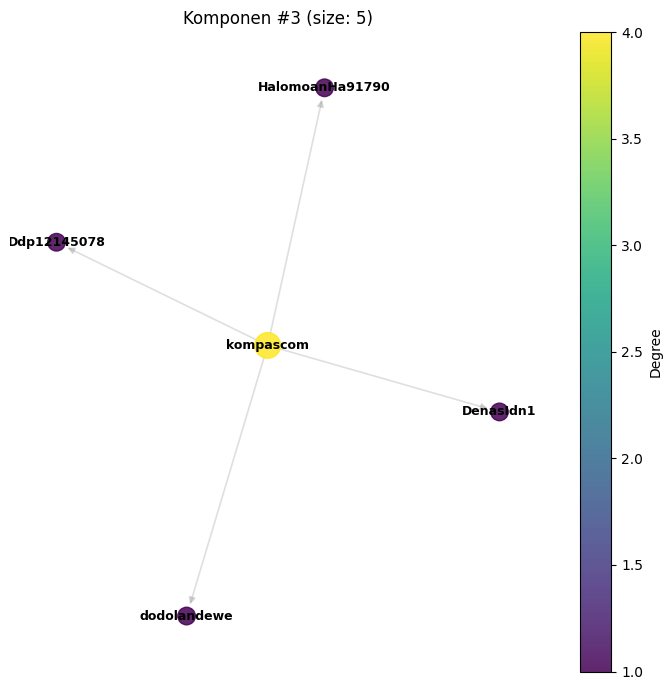

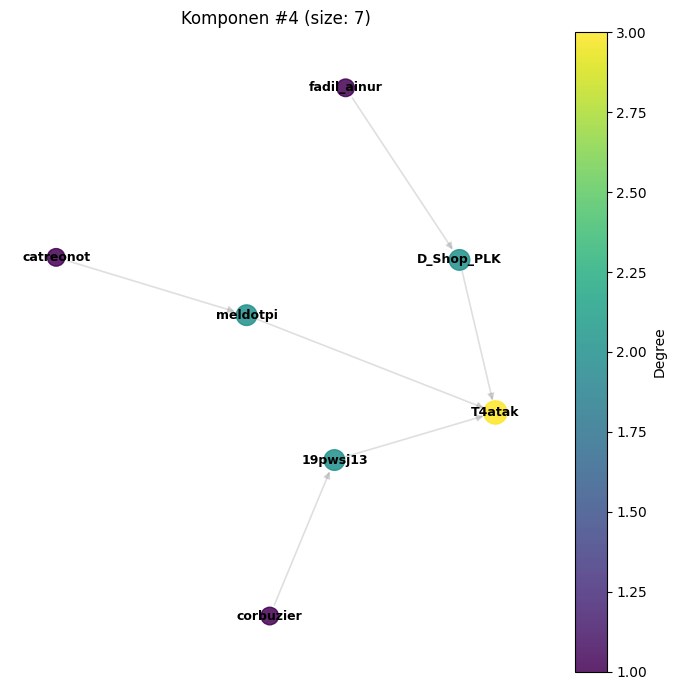

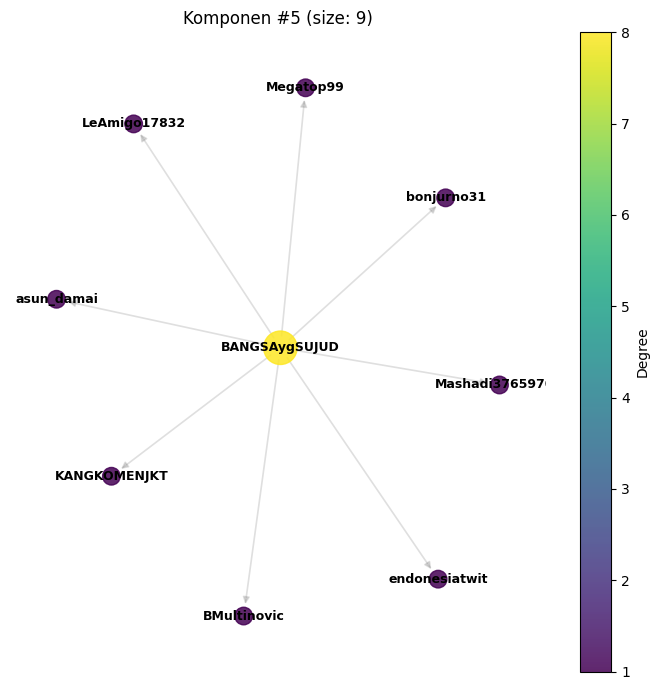

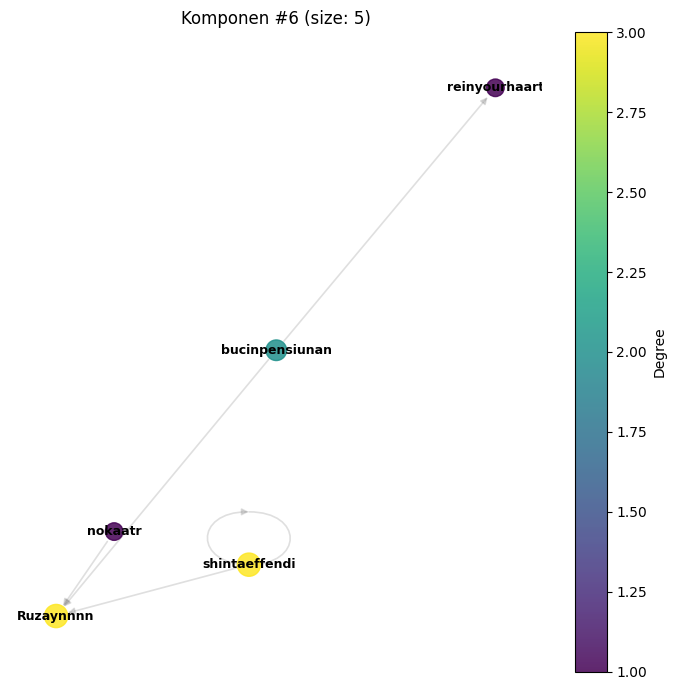

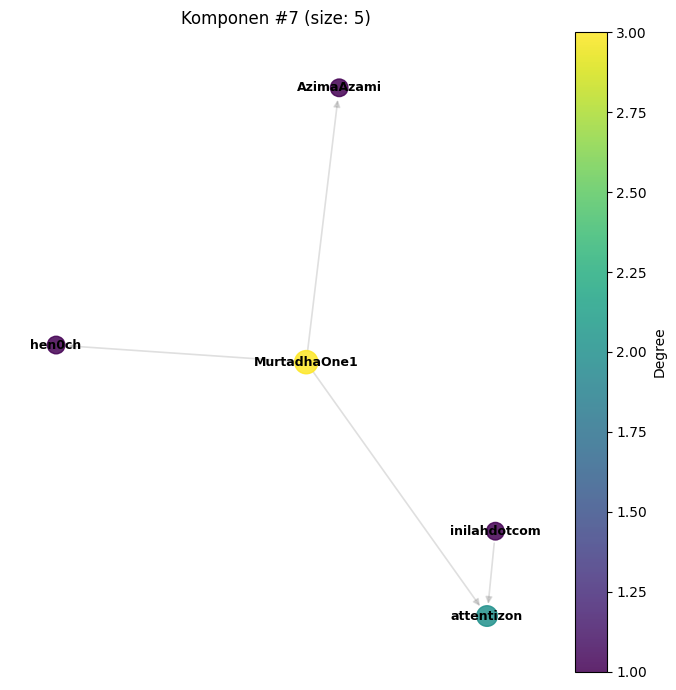

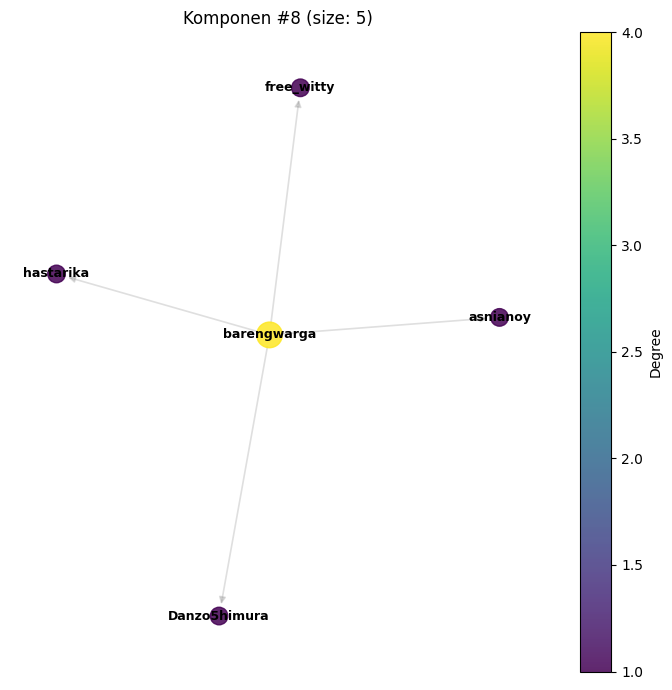

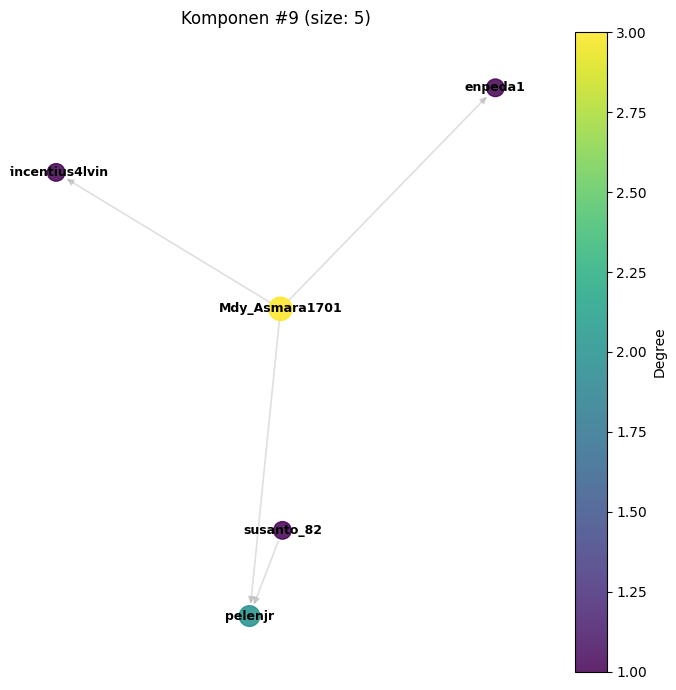

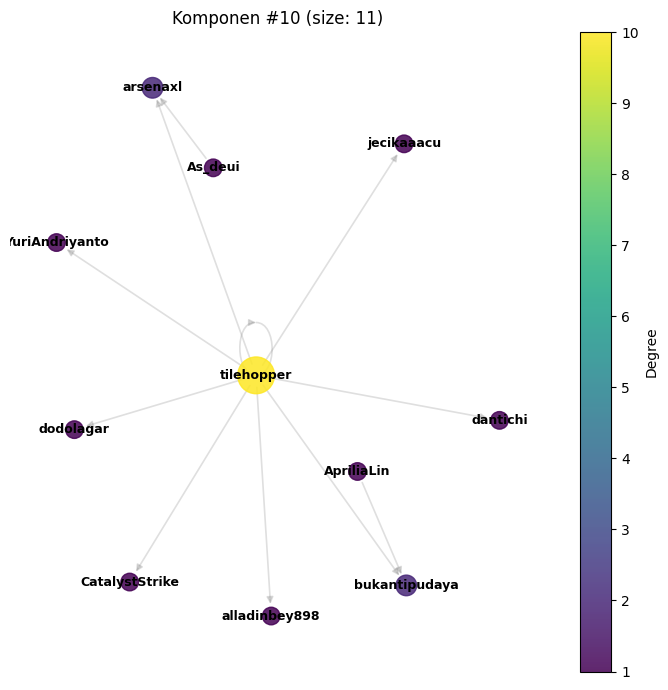

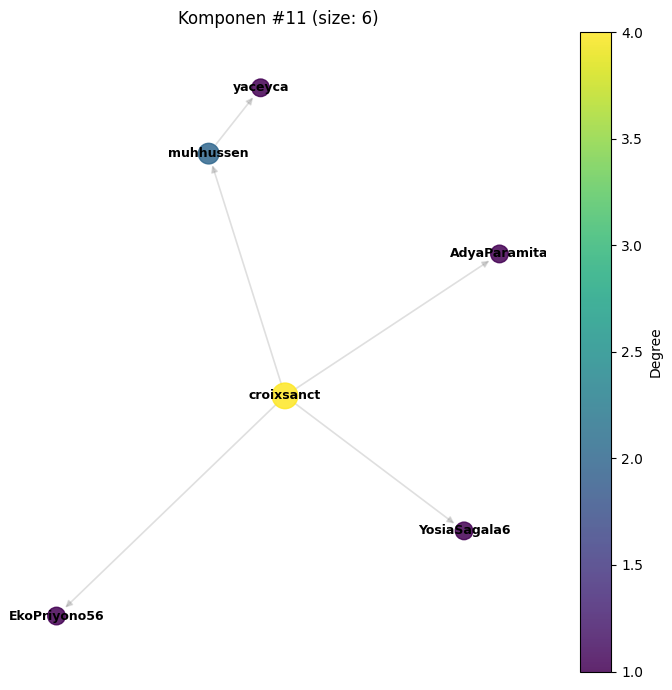

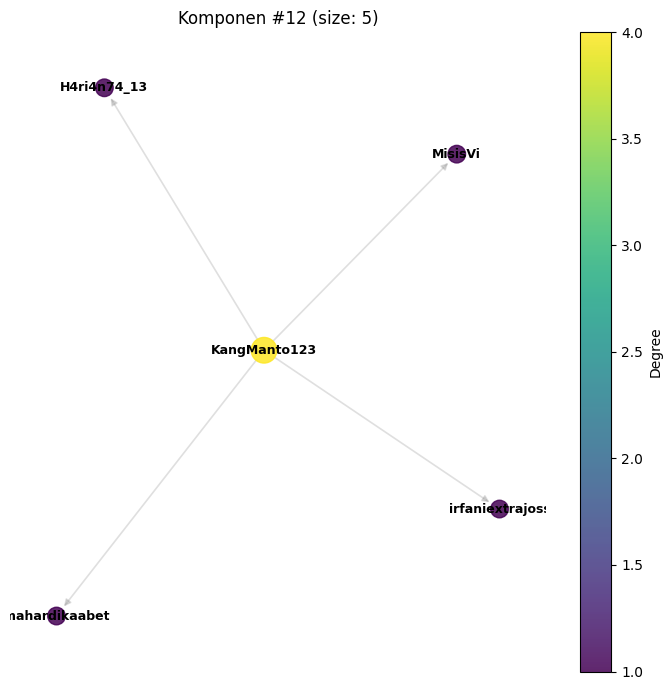

In [69]:
components = list(nx.weakly_connected_components(G))
large_components = [comp for comp in components if len(comp) >= 5]
print(f"Jumlah komponen dengan size >= 5: {len(large_components)}")
for i, comp in enumerate(large_components):
    subgraph = G.subgraph(comp)
    plt.figure(figsize=(7, 7))
    pos = nx.spring_layout(subgraph, k=0.5, seed=42)  # Seed for reproducibility

    # Node color by degree
    degrees = dict(subgraph.degree())
    node_colors = [degrees[n] for n in subgraph.nodes()]
    nodes = nx.draw_networkx_nodes(
        subgraph, pos, node_size=[v*60+100 for v in degrees.values()],
        node_color=node_colors, cmap=plt.cm.viridis, alpha=0.85
    )
    nx.draw_networkx_edges(subgraph, pos, alpha=0.25, width=1.2, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')
    plt.title(f'Komponen #{i+1} (size: {len(comp)})')
    plt.axis('off')
    plt.colorbar(nodes, label='Degree')
    plt.tight_layout()
    plt.show()

## Analisis Jaringan Temporal Lanjutan

## Fungsi Analisis Jaringan Temporal Lanjutan

In [62]:
def create_temporal_networks(df, time_windows):
    networks = []
    for window in time_windows:
        df_subset = df[df['hours_since_first'] <= window]
        G = nx.DiGraph()
        for _, row in df_subset.iterrows():
            if pd.notna(row['username']) and pd.notna(row['in_reply_to_screen_name']) and row['username'] != 'grok':
                G.add_edge(row['in_reply_to_screen_name'], row['username'],
                          timestamp=row['hours_since_first'])
        networks.append((window, G))
    return networks

def find_longest_paths(G):
    if G.number_of_nodes() == 0:
        return []
    longest_paths = []
    max_length = min(20, G.number_of_nodes())
    source_candidates = sorted(G.nodes(), key=lambda x: G.out_degree(x), reverse=True)[:50]
    for source in source_candidates:
        for target in G.nodes():
            if source != target:
                try:
                    paths = list(nx.all_simple_paths(G, source, target, cutoff=max_length))
                    for path in paths:
                        longest_paths.append((len(path), path, source, target))
                except (nx.NetworkXNoPath, nx.NetworkXError):
                    continue
    longest_paths.sort(key=lambda x: x[0], reverse=True)
    return longest_paths

def analyze_diffusion_tree(G, source_node):
    if source_node not in G.nodes():
        return None
    tree = nx.DiGraph()
    visited = set()
    queue = deque([(source_node, 0)])
    level_nodes = defaultdict(list)
    while queue:
        current_node, level = queue.popleft()
        if current_node in visited:
            continue
        visited.add(current_node)
        level_nodes[level].append(current_node)
        for successor in G.successors(current_node):
            if successor not in visited:
                tree.add_edge(current_node, successor)
                queue.append((successor, level + 1))
    return {
        'tree': tree,
        'levels': dict(level_nodes),
        'max_depth': max(level_nodes.keys()) if level_nodes else 0,
        'total_influenced': len(visited) - 1
    }

def print_all_levels_detail(tree_analysis, source_node, importance):
    print(f"\nSource: {source_node} (Importance: {importance})")
    print(f"Total influenced users: {tree_analysis['total_influenced']}")
    print(f"Maximum diffusion depth: {tree_analysis['max_depth']} levels")
    print(f"Users per level:")
    for level in sorted(tree_analysis['levels'].keys()):
        nodes = tree_analysis['levels'][level]
        print(f"  Level {level}: {len(nodes)} users")
        if len(nodes) <= 10:
            print(f"    Users: {', '.join(nodes)}")
        else:
            print(f"    Users: {', '.join(nodes[:10])} ... and {len(nodes)-10} more")

def get_level_colors(max_level):
    if max_level <= 1:
        return ['red', 'orange']
    base_colors = ['red', 'orange', 'yellow', 'lightgreen', 'lightblue', 
                   'pink', 'purple', 'brown', 'gray', 'olive']
    if max_level + 1 <= len(base_colors):
        return base_colors[:max_level + 1]
    else:
        cmap = plt.cm.get_cmap('tab20')
        colors = [cmap(i / max_level) for i in range(max_level + 1)]
        return colors

## Snapshot Temporal, Longest Path, dan Node Importance

In [63]:
# Snapshot temporal
max_hours = df['hours_since_first'].max()
time_windows = np.linspace(max_hours/5, max_hours, 5)
temporal_networks = create_temporal_networks(df, time_windows)

# Longest path
final_window, final_network = temporal_networks[-1]
longest_paths = find_longest_paths(final_network)
print(longest_paths)
# Node importance
node_importance = {}
for node in final_network.nodes():
    out_degree = final_network.out_degree(node)
    in_degree = final_network.in_degree(node)
    node_importance[node] = out_degree * 2 + in_degree

[(3, ['KompasTV', 'ftriningsih_', 'tukang_rejceh'], 'KompasTV', 'tukang_rejceh'), (3, ['croixsanct', 'muhhussen', 'yaceyca'], 'croixsanct', 'yaceyca'), (3, ['fadil_ainur', 'D_Shop_PLK', 'T4atak'], 'fadil_ainur', 'T4atak'), (2, ['ARSIPAJA', 'noirsanity'], 'ARSIPAJA', 'noirsanity'), (2, ['ARSIPAJA', 'bukunonfiksi'], 'ARSIPAJA', 'bukunonfiksi'), (2, ['ARSIPAJA', 'idkidcu'], 'ARSIPAJA', 'idkidcu'), (2, ['ARSIPAJA', 'yamaugimanslagi'], 'ARSIPAJA', 'yamaugimanslagi'), (2, ['ARSIPAJA', 'zaka_michi'], 'ARSIPAJA', 'zaka_michi'), (2, ['ARSIPAJA', 'sobbuah'], 'ARSIPAJA', 'sobbuah'), (2, ['ARSIPAJA', 'Achmad_Fah'], 'ARSIPAJA', 'Achmad_Fah'), (2, ['ARSIPAJA', 'reosandyraihan'], 'ARSIPAJA', 'reosandyraihan'), (2, ['ARSIPAJA', 'bronoordien'], 'ARSIPAJA', 'bronoordien'), (2, ['ARSIPAJA', 'sky_transparan'], 'ARSIPAJA', 'sky_transparan'), (2, ['ARSIPAJA', 'boeronan'], 'ARSIPAJA', 'boeronan'), (2, ['ARSIPAJA', 'Aa363738'], 'ARSIPAJA', 'Aa363738'), (2, ['ARSIPAJA', 'Farasismyname'], 'ARSIPAJA', 'Farasismy

## Analisis & Visualisasi Diffusion Tree dengan Depth Terpanjang

In [64]:
# Temukan 5 node sumber dari diffusion tree dengan depth terpanjang
max_trees = 10
best_trees = []
used_sources = set()
for length, path, source, target in longest_paths:
    if source in used_sources:
        continue
    tree_analysis = analyze_diffusion_tree(final_network, source)
    if tree_analysis:
        best_trees.append((source, tree_analysis))
        used_sources.add(source)
    if len(best_trees) >= max_trees:
        break

for i, (source, tree) in enumerate(best_trees, 1):
    print(f"\nTree #{i} - Source: {source}")
    print_all_levels_detail(tree, source, node_importance.get(source, 0))


Tree #1 - Source: KompasTV

Source: KompasTV (Importance: 16)
Total influenced users: 9
Maximum diffusion depth: 2 levels
Users per level:
  Level 0: 1 users
    Users: KompasTV
  Level 1: 8 users
    Users: maymarmas, FirdausyMuh, ftriningsih_, PenculikBangsat, Rizal_489, Asakura_Kana87, AgusTia79936952, NdoeL_2011
  Level 2: 1 users
    Users: tukang_rejceh

Tree #2 - Source: croixsanct

Source: croixsanct (Importance: 8)
Total influenced users: 5
Maximum diffusion depth: 2 levels
Users per level:
  Level 0: 1 users
    Users: croixsanct
  Level 1: 4 users
    Users: muhhussen, YosiaSagala6, AdyaParamita, EkoPriyono56
  Level 2: 1 users
    Users: yaceyca

Tree #3 - Source: fadil_ainur

Source: fadil_ainur (Importance: 2)
Total influenced users: 2
Maximum diffusion depth: 2 levels
Users per level:
  Level 0: 1 users
    Users: fadil_ainur
  Level 1: 1 users
    Users: D_Shop_PLK
  Level 2: 1 users
    Users: T4atak

Tree #4 - Source: ARSIPAJA

Source: ARSIPAJA (Importance: 30)
Total

## Visualisasi 5 Diffusion Tree Terpanjang

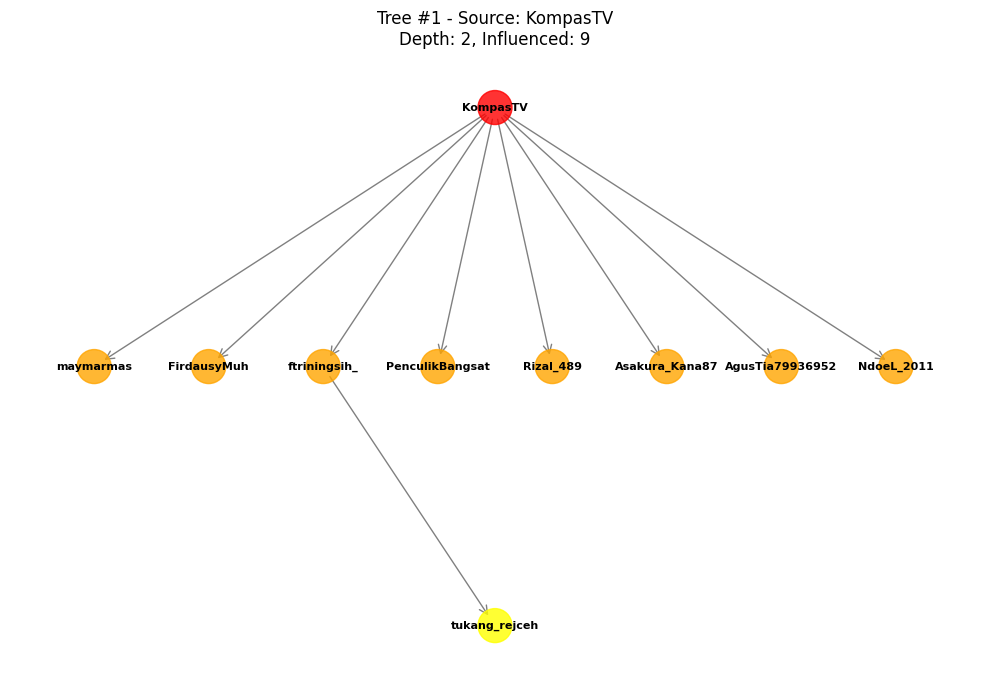

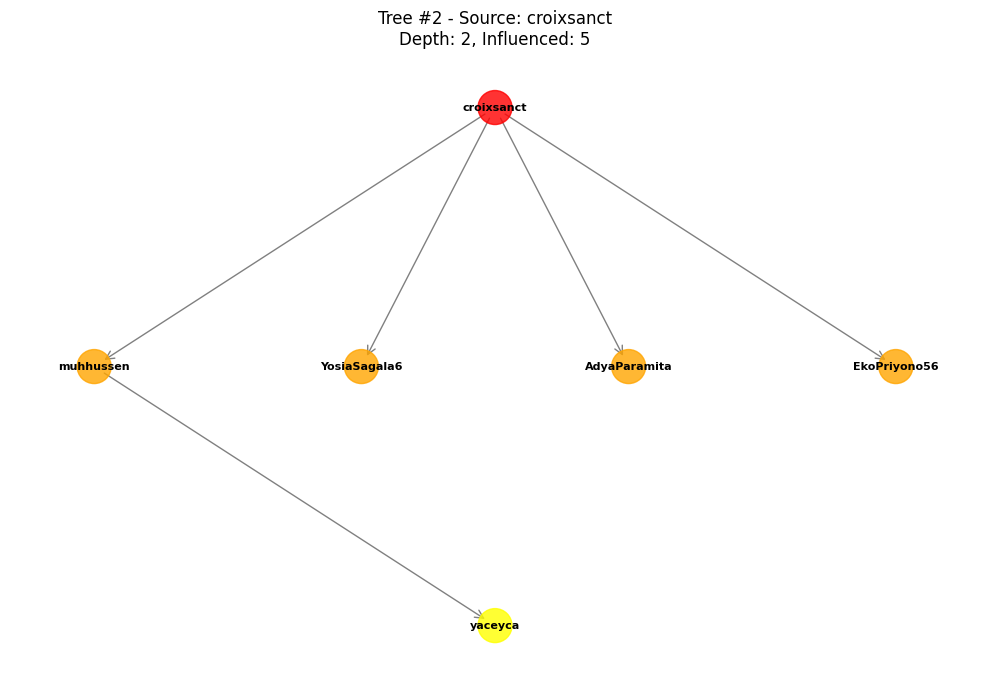

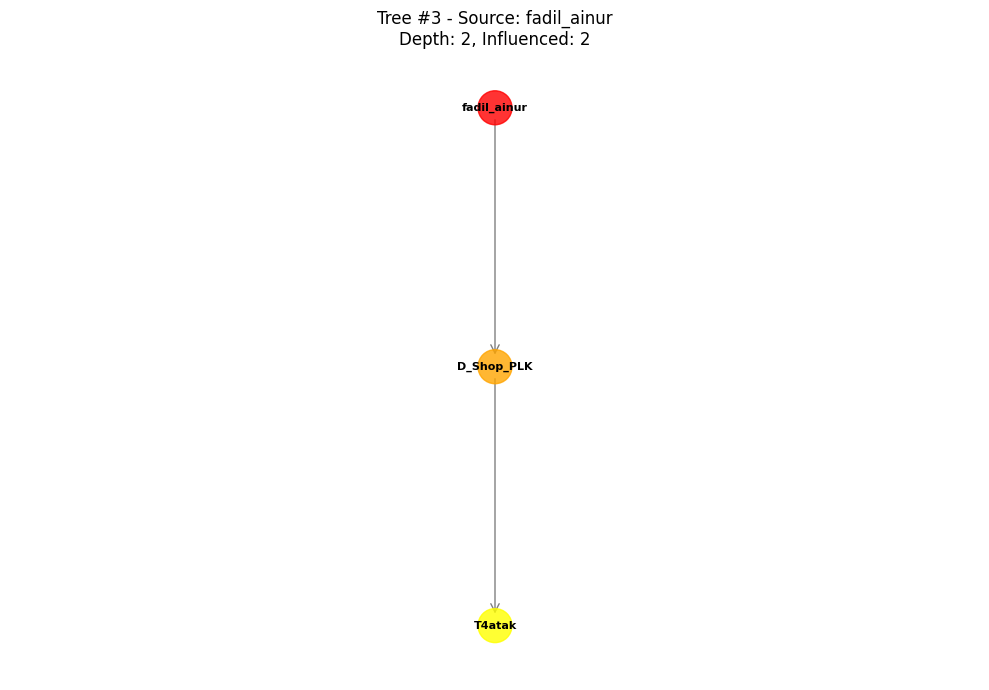

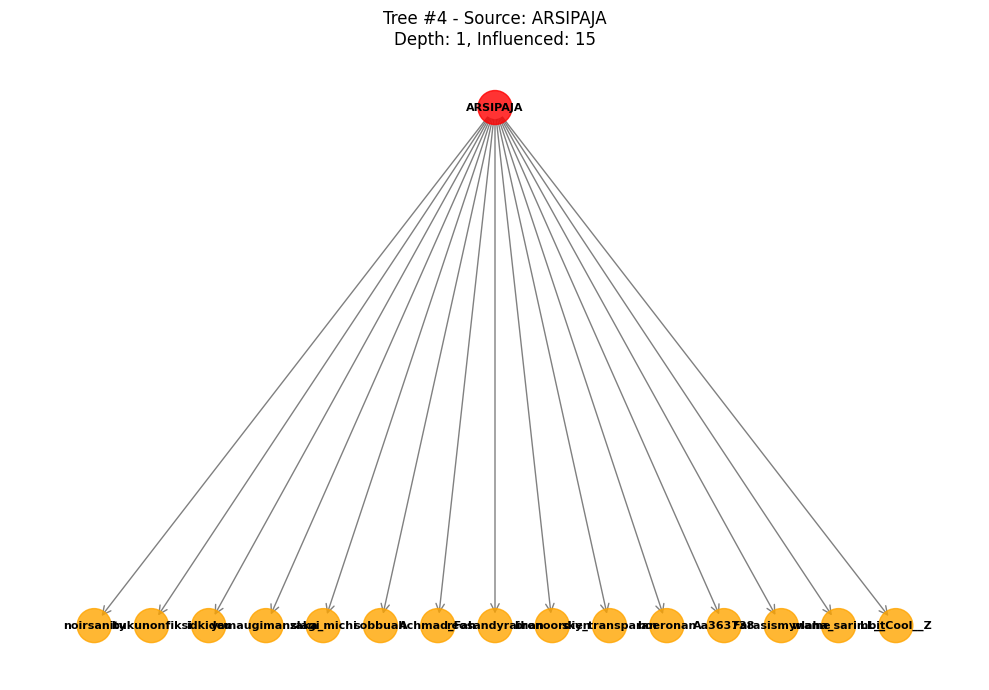

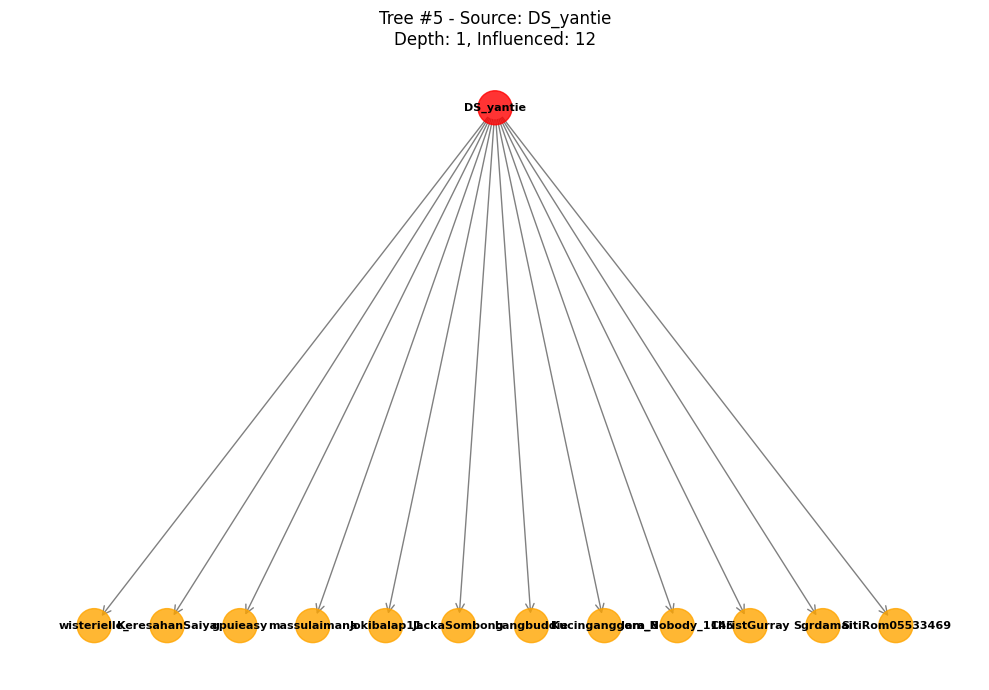

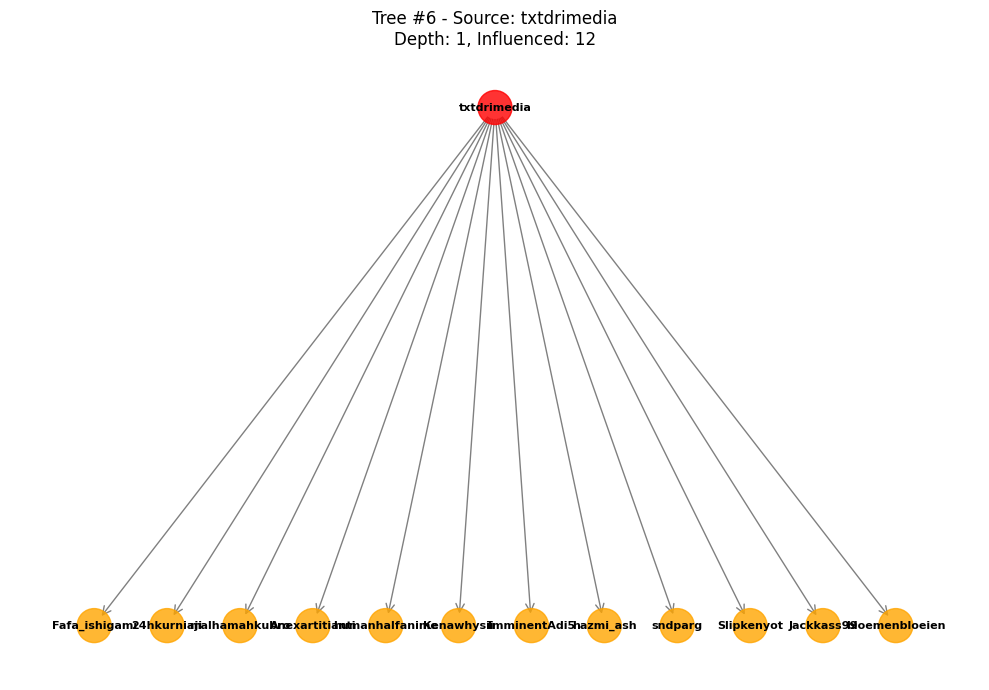

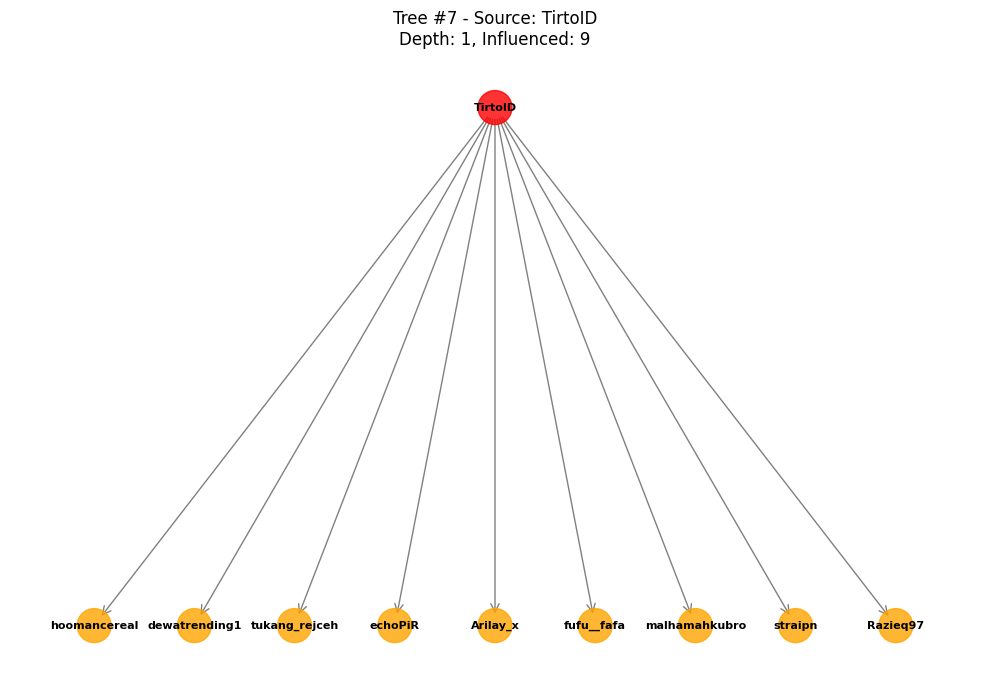

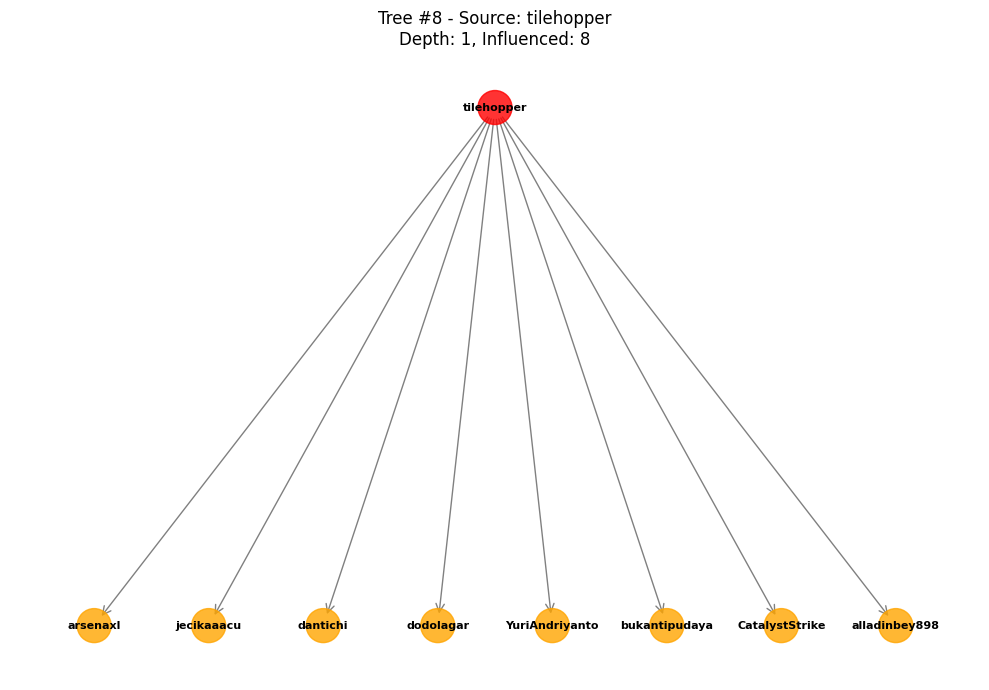

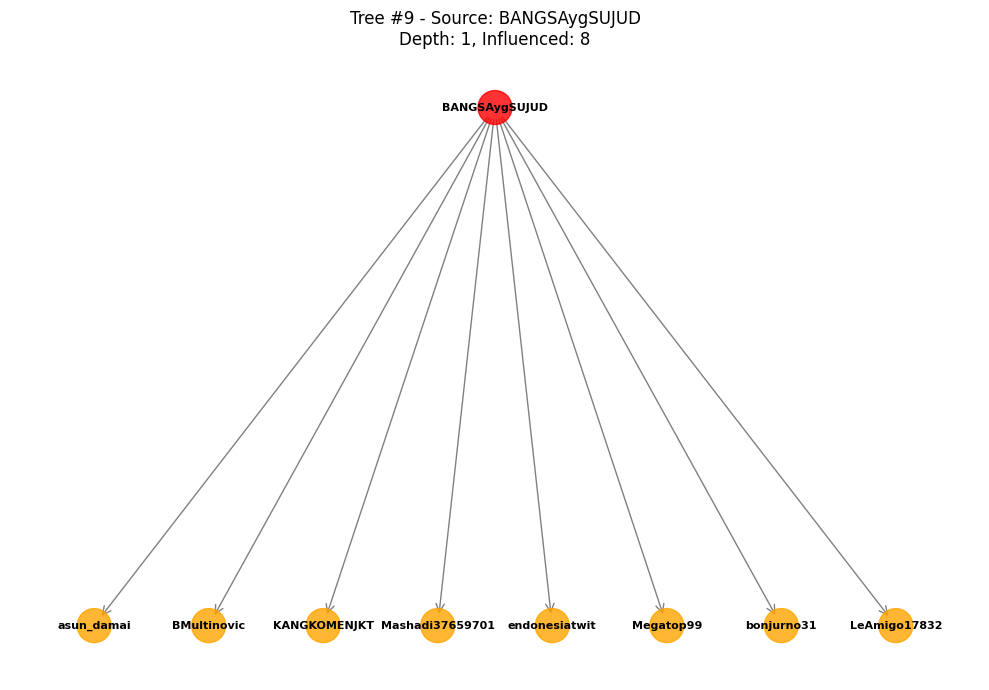

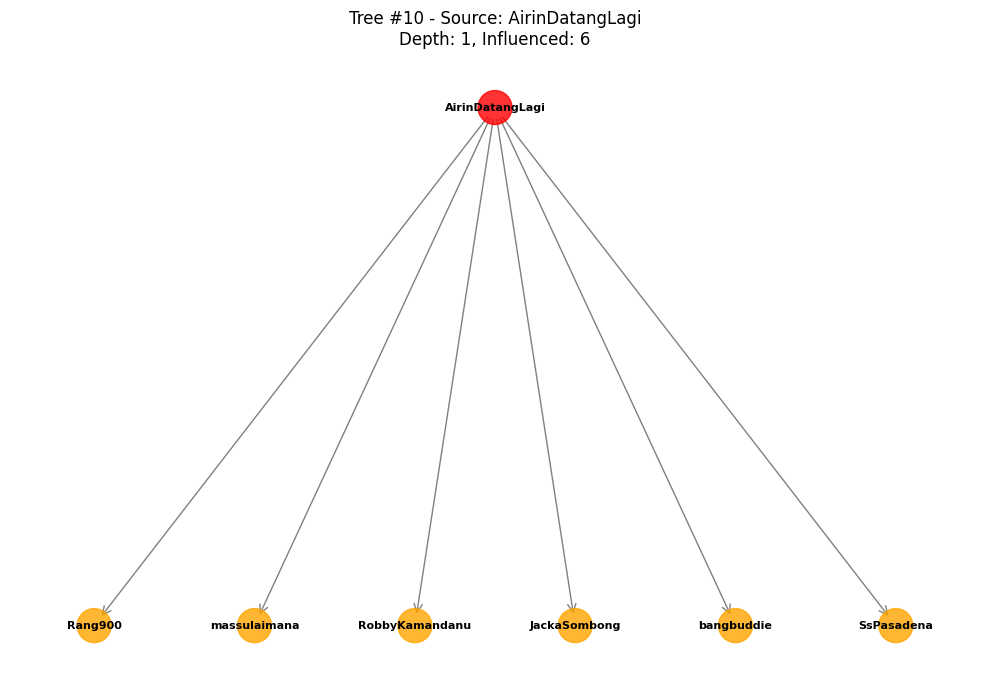

In [65]:
for i, (source, tree_data) in enumerate(best_trees, 1):
    tree = tree_data['tree']
    levels = tree_data['levels']
    max_level = tree_data['max_depth']
    level_colors = get_level_colors(max_level)
    pos = {}
    for level, nodes in levels.items():
        y = -level
        for j, node in enumerate(nodes):
            x = j - (len(nodes) - 1) / 2
            pos[node] = (x, y)
    node_colors = []
    for node in tree.nodes():
        node_level = None
        for level, nodes in levels.items():
            if node in nodes:
                node_level = level
                break
        if node_level is not None and node_level < len(level_colors):
            node_colors.append(level_colors[node_level])
        else:
            node_colors.append('lightgray')
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(tree, pos, node_color=node_colors, node_size=600, alpha=0.8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowstyle='->', arrowsize=15)
    nx.draw_networkx_labels(tree, pos, font_size=8, font_weight='bold')
    plt.title(f'Tree #{i} - Source: {source}\nDepth: {max_level}, Influenced: {tree_data["total_influenced"]}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()